# American options and the grid

Last session we computed European calls and puts using the trinomial tree method. In the limit of many time steps (large $N$) we checked that the numerical result gets closer and closer to what we know should be the value: the Black-Scholes formula. 

In this notebook, we will continue and use the tree to compute the value of an option type that we do not have a ready formula for: an American option.

Recall the difference between American and European options: a European option can only be exercised at the maturity time (the end date of the option). A European call option with strike price $K$, for instance, gives you a pay-off $S-K$ if the stock price $S$ at the maturity date is larger than the strike price, $K$ (and zero if $S$ is lower than $K$.

An American option, in contrast, gives the owner the right to exercise, and immediately get the difference $S-K$, at *any chosen time* up to the maturity time. If you think that your stock has reached its maximum level today, and will only decline from now on, an Americal option lets you get $S-K$ now, rather than waiting until maturity when the stock price might have again gone down.

It will only make sense, of course, to exercise an American option (that has not yet reached its maturity) if $S$ is bigger than $K$ (you do not volunteer to get a low value stock at a high price). But the requirement for exercising optimally is actually stronger: you will only want to exercise the option, if getting $S-K$ now is worth more than keeping the option alive (and being able to exercise, for instance, tomorrow). This observation will be driving the numerical approach to value American options here.

**Note:** Options that are traded on exchanges are typically of the American style.



## Modelling an American option

Let us first again define all functions that we have from our previous notebook on the European call option, by running the following cells. Review all those function definitions, and make sure you recall what they do and why. 

First, import the standard libraries for computation, numpy, and plotting, matplotlib.pyplot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We next need to define the payoff for a call option at maturity.

In [ ]:
def call_payoff(strike, S_array):
    # create an array of strikes that is of the same size as the stock price array
    # len() is a functions that measures how big some array is
    length_of_S_array= len(S_array)
    strike_array=strike*np.ones(length_of_S_array)
    # now create an array of that same length (number of elements) that gives the 
    # payoff values for a call option
    values=np.maximum(S_array-strike_array,0)
    return values

Then define the parameters of the trinomial tree: the stock price values and the transition probabilities in the tree

In [ ]:
def set_parameters(S_0, T, r, sigma, div, N):
    
    # define the parameters as just outlined:
    
    dt = T/N
    dx = sigma*np.sqrt( 3*dt )
    nu = r- div- 0.5 * sigma**2
    
    pu = (1/2)*dt* ( (sigma/dx)**2 + nu/dx )
    pm = 1 - dt*(sigma/dx)**2 - r*dt
    pd = (1/2) * dt * ( (sigma/dx)**2 - nu/dx )
    
    # define the array of stock prices: it will be 2N+1 elements long, with S_0 as the middle value
    # each value up will be e^dx larger, while a value down will be e^(-dx) smaller

    S_array = S_0 * np.exp(dx * np.linspace(-N,N, 2*N+1))
    
    #this function gives as output the three probabilities and the 2N+1 array of stock prices.
    return pu, pm, pd, S_array

We next have the function that makes one backward step in the tree

In [ ]:
def step_back_tree(pu,pm,pd, values,n):
    # n measures how many steps back from the endpoints of the tree we are:
    # n=1 is the first iteration (stepping back from the final values at maturity to one 
    # time-period before that), etc., until at n=N we reach the initial node, the root of the tree.
    
    #first check how long your input array of values is
    length = len(values)
    
    # prepare the output array as one filled with zeros
    option_values = np.zeros(length)
    
    # now step back, filling only the center elements with values, and leave the first n elements,
    # and the last n elements, equal to zero
    option_values[n:length-n] = pu*values[n+1:length-n+1]+pm*values[n:length-n] \
    +pd*values[n-1:length-n-1]
    
    return option_values

and finally the function that combines these ingredients to compute the trinomial tree value for the European call option

In [ ]:
def European_call_option(S_0, T, r, sigma, div, N, strike):
    
    # first set the parameters; note that this function gives a whole bunch of outputs at once:
    pu, pm, pd, S_array = set_parameters(S_0, T, r, sigma, div, N)
    
    #next, define the payoffs for the option at the end points, for the given strike price
    values= call_payoff(strike, S_array)
    
    #now use a for-loop to step back N times to produce the initial values
    for n in range(1,N+1):
        intermediate_option_prices=step_back_tree(pu,pm,pd, values,n)
        values = intermediate_option_prices  #update our values-array for the next step
        
    
    return values[N] # we want to get the middle (index N) element of this array, 
                        #which corresponds to the root of the tree  

Make sure you executed each of these cells. Let's try it out once again for a particular choice of option parameters. Note below how we give the numerical values of our choice a name, and substitute those names as arguments in the function we have defined. 

In [ ]:
stockprice=100
maturity=1
interestrate=0.06
volatility=0.2
dividendrate=0.03
steps=10000
strikeprice=100

European_call_option(stockprice, maturity, interestrate, volatility, dividendrate, steps, strikeprice)


Now we are in a position to adapt this function into an American option. To see how it works, let us first again, for simplicity, consider a tree with only one step, or **steps**=1. Also, let us change some of the other parameters: set **dividendrate** to 0.10, and set **strikeprice** to 80. Change the values of **steps**,  **dividendrate** and **strikeprice** and recompute the option price.

(I found an option price of approximately 17.05).
In this one-step trinomial tree, there are three end points. What are the stock prices at the three end points? And what are the three option values at those points? Calculate these using some of the functions that we have already defined above.

Let us put ourselves in the position of the owner of this call option. If the world is of the simple one-step trinomial tree kind, the value of this European option today is 17.05. In contrast, suppose we were given the choice: do you want to keep on holding this option until maturity (and exercise it whenever stock price at maturity is above the strike price), or do you want to exercise this option right now? What would you choose?

An American option offers just that choice: if it is more profitable to exercise the option right now, than to keep the option alive for a bit longer, you will exercise.
What would be the *value* of the American option in the above one-step world?

In our one-step tree world, we can compute the value of the American option: it is the maximum of exercising right now, or holding to maturity. The value of holding to maturity is the European option price. So 
$$
\mbox{American option (1 step tree)}=\max \left(\mbox{European option (1 step tree)}, S-K\right)
$$

Let us now extend this for multiple steps: consider the two-step example we looked at last session. In that case, the tree has five end points. Assign the new parameter values (in particular, **steps=2**), and compute the stock and option values in each end point, as follows:

In [ ]:
steps =2
dividendrate=0.10
strikeprice=80
pu, pm, pd, S_array = set_parameters(stockprice, maturity, 
                                     interestrate, volatility, dividendrate, steps)
option_payoffs=call_payoff(strikeprice, S_array)    

In [ ]:
S_array

In [ ]:
option_payoffs

Check that the stock prices, and the accompanying option values if the option is exercised at the maturity (the last step) are as in the diagram below.

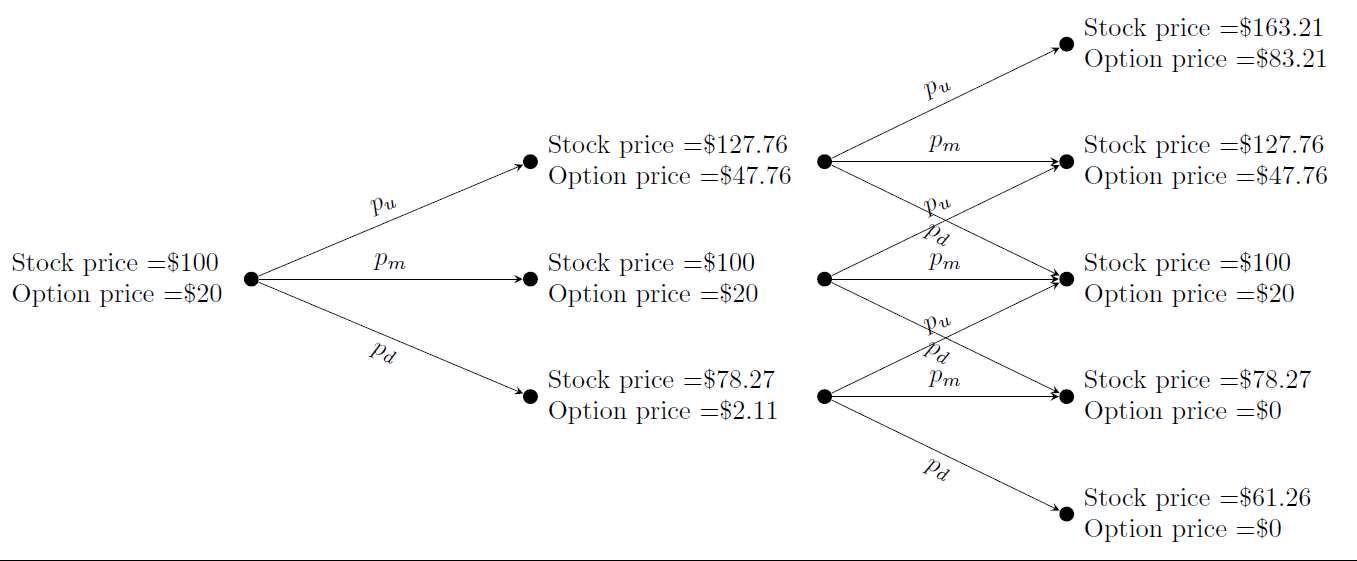

Now let us first step back once, and compute the option values in the intermediate step, in the three nodes half-way the tree.
Note that we can do this using our function **step_back_tree()**, which takes as inputs 
* the three probabilities, **pu, pm** and **pd**, that we have already computed and assigned above; 
* and the five option values at the five end nodes, that have been assigned to the variable **option_payoffs**; 
* and finally, the input $n=1$, to indicate this is the first step back.

Use these as inputs to compute the option prices in the three nodes half way. Verify that they are equal to 2.11, 17.77, and 43.74.

Now consider the owner of an American option, finding him/herself at the middle node halfway, where the value of the stock is 100, and the value of keeping the option, just computed, is 17.77 What would (s)he do? Well, in this case, exercising the option early gives a pay-off of $100-80=20$, while keeping the option alive is worth only 17.77. So surely, early exercise is optimal here. The value of having the option in this node is therefore higher than 17.77, we should change it to 20, as we have done in the picture above.

Similarly for the upper node half-way: exercising early is worth 47.76 here, which is more than the value of the option if we keep it alive until the end date, 43.74. So we have to revise the value also in this node to reflect the value of early exercise.

Only in the lower node, the value of keeping the option alive, 2.11, dominates that of exercising the option right away (which gives zero, since the stock price here is lower than the strike price of 80).

Check that in the picture above, we have adapted option values half-way, to reflect that value of early exercise.

We can do the updating in numpy by again using the **np.maximum()** function. Check that we can get the appropriate American option values halfway by evaluating

In [ ]:
American_option_values_halfway=np.zeros(5)
American_option_values_halfway[1:4]=np.maximum(step_back_tree(pu,pm,pd, option_payoffs,1)[1:4],
                                               option_payoffs[1:4])

Does it give the required output? Check it!

Note how we used *slicing* on the array: we only want to re-assign the elements indexed 1, 2 and 3, and want to keep the upper and lower indices equal to zero.

In [ ]:
American_option_values_halfway

To get the option value at the initial node, we again have to step back, using the **American_option_values_halfway** as an input. Again use the same **step_back_tree()** function, with the same probabilities, the half-way option prices, and now $n=2$ to denote the second step. What is the option value we find for the first node? Check that is equals 18.25.

Again we have to ask: at the initial point, would the owner keep the option alive (average worth 18.25), or would it be optimal to exercise right away?

Clearly, in this case, early exercise is optimal (it gives 20 right away). So the value of the American option in this example is actually equal to 20, and the option should be exercised at $t=0$.

In [ ]:
step_back_tree(pu,pm,pd, American_option_values_halfway,2)

The procedure for computing an American option value, in general, is then as follows:
* start by computing the pay-offs at the maturity date
* step back to the step before that date, compute option prices as before, computing weighted averages in each node as in the European option, using probabilities $p_u,p_m,p_d$.
* NEW: update those option values by checking whether early exercise might give a better value, and if so replacing the value with the early exercise value
* step back again, and repeat this procedure, until ending up at the initial node

It now remains to alter the function to reflect that NEW updating step, replacing values by early exercise values if that gives a higher pay-off. Check that this is exactly what is done in the function 

In [ ]:
def American_call_option(S_0, T, r, sigma, div, N, strike):
    
    # first set the parameters; note that this function gives a whole bunch of outputs at once:
    pu, pm, pd, S_array = set_parameters(S_0, T, r, sigma, div, N)
    
    #next, define the payoffs for the option at the end points, for the given strike price
    values= call_payoff(strike, S_array)
    
    #now use a for-loop to step back N times to produce the initial values
    for n in range(1,N+1):
        intermediate_option_prices=step_back_tree(pu,pm,pd, values,n)
        values = intermediate_option_prices  #update our values-array for the next step
        #The NEW step: we want to check for early exercise: 
        #update the values with the early-exercise value if that gives a higher pay-off
        values[n:2*N+1-n]=np.maximum(values[n:2*N+1-n],call_payoff(strike, S_array)[n:2*N+1-n])
    
    return values[N] # we want to get the middle (index N) element of this array, 
                        #which corresponds to the root of the tree  

Again, in the line where the maximum is applied, check the *slicing* over the required index values: does this function apply the maximum to the non-zero elements at each step (indexed by $n$)?

Now, we can use this function to find the value for any number of steps. Recall: the higher the number of steps, the closer we approximate the *real* continuous model of the stock price movements.

In [ ]:
stockprice=100
maturity=1
interestrate=0.06
volatility=0.2
dividendrate=0.1
steps=2
strikeprice=80

American_call_option(stockprice, maturity, interestrate, volatility, dividendrate, steps, strikeprice)

With these parameters, and a higher number of steps (e.g. 1000), does it remain optimal to exercise at $t=0$?
What if the strike price is higher, say 85; would one still exercise immediately?

### Exercise
We do not have an analytic expression for the American option price. We do know that the true value is approximated if we take the number of steps high enough. But how high is high enough?
For the American option above, but with strike price equal to 100, explore this: how high do you need to take the number of steps so that doubling that number of steps does not change the result by more than 0.01? 

Of course, the greater the precision desired, the larger the number of steps. At some point you will run into your computer's computing power limits, where the computation takes too long for your patience. Also explore when that happens.

How does the American option value you computed compare with the value of the corresponding European option, with the same parameters? 

# Extending the tree into a grid

We can now compute the value of a European or an American option, with any desired pay-off function. (We concentrated on the call option, but we can change this into any other pay-off function that we desire.)

The answer we get from the trinomial tree computation is one number: the value of the option at one particular initial value for the stock price, namely the stock price at the root of the tree.

Often, we would like to have information on the option value for a whole range of stock prices. For instance, because we want to plot the option price as a function of the stock price. Or, because we want to figure out, in the case of an American option, for what levels of the initial stock price the option will be exercised immediately.

One way to answer such questions would be to just repeat the tree calculation for a number of different starting values of the stock price. But this is cumbersome, and time consuming. Fortunately, there is a more convenient method: extend the (triangular) tree into a (rectangular) grid.

Recall how the tree structure came about as we stepped back: we start with $2N+1$ values at the maturity date. Stepping back once allows us to compute option values one time step before maturity. We can only compute these for $2N-1$ points, however: the top-most and bottom-most values cannot be computed, as these do not connect in a similar way to three nodes (up, middle and down) in the last column of values.

As we go back further, the number of nodes for which we can compute by stepping back keeps going down by $2$ every step. In the end, after $N$ steps, we arrive at the single node at the root of the tree.

We can overcome this problem by just *assigning* a reasonable value to the top and bottom node each step, rather than computing it. Instead of having $2N-1$ option values in the penultimate time step, we add values for the top and bottom node, again creating a fully filled array of $2N+1$ value in that step. And as we continue doing so stepping backwards, we will ultimately have a fully filled array of $2N+1$ option values even at the initial time, $t=0$.

But what is a *reasonable value* to assign to the top and bottom nodes? This question really asks what are the *boundary conditions* for the option at very high and at very low stock price values.

For a call option, if stock prices are really low, the option value should go to zero (in the limit, there is little chance that the option will end up *in the money*). The reasonable value we should choose at the bottom is therefore zero,
$$
option_0=0.
$$

On the other hand, for a call option at very high stock price values, the option value will grow proportionally with the stock price value (the derivative of the option value will tend to one). The reasonable value for the option value at the top-most node should then be equal to the value one node below it, plus the difference in stock prices:
$$
option_{2N+1}=option_{2N} + (S_{2N+1}-S_{2N}).
$$

Once we assigned these values, we can again step back over the entire $2N+1$-array of values, and again assign values to the top-most and bottom-most nodes in the next step. Repeating this until we reach $t=0$, we have found the option prices for all initial stock prices in the array, rather than only in its centre element. 

Let us redefine the **step_back()** function so that we carry out this procedure, to fill the whole rectangular grid, rather than only the triangular area corresponding to the tree.

In [ ]:
def step_back_call(pu,pm,pd, values, S_array):
    # note: no dependence on the step number n anymore, we follow the same procedure in each step!
    # we will need the stock price values, for the boundary conditions, so let's include those
    # as an argument of the function
    
    #first check how long your input array of values is
    length = len(values)
    
    # prepare the output array as one filled with zeros
    option_values = np.zeros(length)
    
    # now step back, first filling all elements except the top and bottom ones:
    option_values[1:length-1] = pu*values[2:length]+pm*values[1:length-1] \
    +pd*values[0:length-2]
    
    # next, let us assign the bottom and top elements, consistent with the boundary conditions
    # for a call option
    
    option_values[0]=0 # zero at the bottom
    option_values[length-1]=option_values[length-2]+ S_array[length-1]-S_array[length-2] 
    # call option value changes linearly with stock prices at the top
    
    
    
    return option_values

Check whether you understand this new step_back function! Note in particular that we can now use the same step back function throughout the whole tree, no need to narrow down the elements as we go back towards the initial time $t=0$.

Next, let us try it out. We will again focus on the situation with two steps, and other parameters as follows:

In [ ]:
stockprice=100
maturity=1
interestrate=0.06
volatility=0.2
dividendrate=0.1
steps=2
strikeprice=100

pu, pm, pd, S_array = set_parameters(stockprice, maturity, 
                                     interestrate, volatility, dividendrate, steps)
option_payoffs=call_payoff(strikeprice, S_array)

Focus on a European option, so no early exercise here. Use the new **step_back_call()** function to verify that the grid is filled as in the following picture.

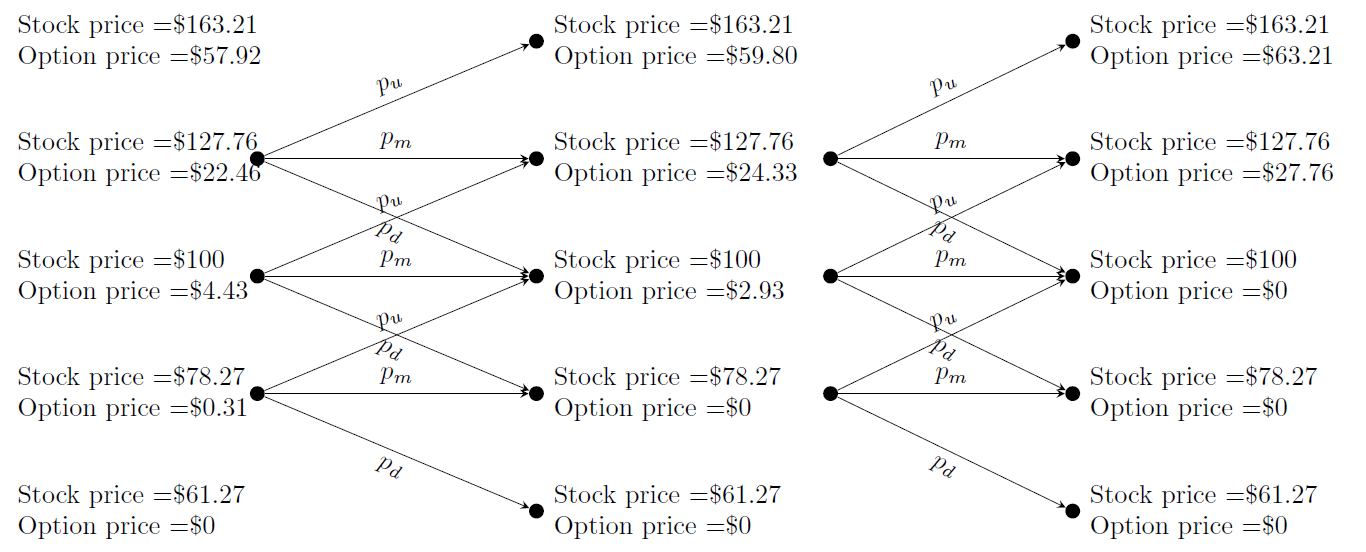

Also, check that the option value computed for the centre node at $t=0$, the option price $\$4.43$, is indeed the same as computed with the trinomial tree method (with the same parameters). What our grid adds, is option values outside of the tree (where previously we would only have put zeros).

To conclude, we can now redefine our previous European and American option functions, now extended to cover the whole grid, rather than just the tree. Check that the following does that for the American call option.

In [ ]:
def American_call_grid(S_0, T, r, sigma, div, N, strike):
    
    # first set the parameters; note that this function gives a whole bunch of outputs at once:
    pu, pm, pd, S_array = set_parameters(S_0, T, r, sigma, div, N)
    
    #next, define the payoffs for the option at the end points, for the given strike price
    values= call_payoff(strike, S_array)
    
    #now use a for-loop to step back N times to produce the initial values
    for n in range(1,N+1):
        #NEW: use our newly defined step back function for the whole grid! It is the
        # same each step, only the input values get updated
        intermediate_option_prices=step_back_call(pu,pm,pd, values, S_array)
        
        values = intermediate_option_prices  #update our values-array for the next step
        #we want to check for early exercise: 
        #update the values with the early-exercise value if that gives a higher pay-off
        
        #NEW: we can do this for the entire array, rather than just the nodes in the tree
        values=np.maximum(values,call_payoff(strike, S_array))
    
    return S_array, values 
# NEW: we want to get the entire array of option values
# NEW: it is also convenient to output the associated array of stock prices: we will need that
# to plot the option value


In [ ]:
stockprice=100
maturity=1
interestrate=0.06
volatility=0.2 
dividendrate=0.1
steps=100
strikeprice=100

stocks, call_prices=American_call_grid(stockprice, maturity, interestrate, volatility, dividendrate, steps, strikeprice)

Observe that, since the function returns not only the array of option prices, but also the array of computed stock prices, we can use it to output both. Check what they look like!

Also we can check that the centre element of either array (indexed by steps, in this case 100) corresponds to the starting stock price of 100, and the associated option price at that level:

In [ ]:
stocks[steps], call_prices[steps]

Now let us plot the graph of the option price (on the y-axis) as a function of the stock price (on the x-axis), as follows:

In [ ]:
fig,ax =plt.subplots()
ax.plot(stocks, call_prices)

The domain is the whole array of stock prices, which is a bit too wide to be able to focus. Let us restrict to stock price values in a slightly smaller domain, e.g. between 50 and 150, and also a suitably restricted y-axis.

In [ ]:
fig,ax =plt.subplots()
ax.plot(stocks, call_prices)
# if you include the next line, you will also see the value of the option if you exercise immediately,
# try it!
#ax.plot(stocks,call_payoff(strikeprice, stocks))
ax.set_xlim([50,150])
ax.set_ylim([0,50])

Can you see from the plot at what current value of the stock price you would exercise the option immediately?

Explore how that changes if you change the precision of the computation, by making the number of steps larger.

# Exercises

* Create a similar function for the whole grid, but now for a European call option. (Copy the **American_call_grid()** code, and adapt what you need to adapt.) Plot the function, and compare with a plot of the exact solution, i.e. the graph of the Black-Scholes formula. Zoom in to see the differences

* Make a function for valuing an American put option. Note: this also means you have to define a **put_payoff()** function, and a **step_back_put()** function. You have to think about the correct boundary conditions, at the top and bottom nodes, for this case! Plot the resulting values and find out below what stock price level the put option will be exercised immediately.

# Projects

We have now done the basics: we can value standard European and American style options where stock prices move as in a Black-Scholes world. We looked at call options in particular, but essentially we can change the final pay-off to any function that we desire, one particular example being the put-option, where the pay-off at maturity is $\max(K-S,0)$.

From here, you are invited to explore further extensions with your project team. You are welcome to come up with ideas yourself, and if you like discuss them with me; but let me just list a number of suggestions here.

Relatively straightforward extensions
* Bermudan options: 
these are in between American and European options: you have the option to exercise before maturity, but only in some specified time-window, for instance the first day of each month.

* barrier options: 
the option only exists as long as the stock price does not cross some prespecified barrier level. E.g. an up-and-out call option with barrier at stock price 120 would be like a regular call option, except it is terminated as soon as the stock price surpasses a level of 120. (Similarly, e .g. up-and-in options: they only come into existence when the stock price crosses that level.) Simple barrier options also have analytic expressions, look them up and compare your numerical result.
Some background literature on efficient valuation of barrier options (on the grid) can be found in the book by Clewlow and Strickland.

* Real options:
For those who did the Energy and Finance course: a simple real option is like an American option, but with an infinite maturity (it lives until you decide to exercise it). See also the exam question on this in last January's exam! You can use the grid to numerically value this option (take time to maturity relatively long). Can you compare the value you compute to the analytical value of the real option?

More challenging:
* Look-back options: e.g. you get the highest stock price achieved during the lifetime of the option, minus the strike price. This is more complicated because this option's pay-off is path-dependent: you have to add an additional dimension to keep track of the highest value achieved in the past. Have a look at the book by Clewlow and Strickland to get some idea about how this might work.

* Options on multiple assets: e.g. a basket option: you get the maximum of the value of two different stocks. Here you have to model two stock prices, that is extend the grid in one more dimension. Think about it, and discuss with me how this might be done.

* More involved real options: e.g. what happens when it takes some time between the decision to build an asset, and the moment it starts producing (time-to-build).

* Departing from the Black-Scholes world. This means adjusting the grid points, and the probabilities $p_u,p_m,p_d$, to reflect more realistic characteristics of the stock price movement (e.g. matching to forward prices, and modelling the so-called volatility smile). Have a look in the book by Clewlow and Strickland for this.